# Script for identifying marine heatwaves (MHWs) in the Barents Sea

#### First, as we are using Python we need to import some libraries. To quickly run a cell :"Ctrl+Enter". Try it with the cell bellow to import the libraries.

In [11]:
import copernicusmarine
from pprint import pprint
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import datetime
from datetime import date
import pandas as pd
import csv

#### To avoid warning messages run the cell below:

In [12]:
import warnings
warnings.filterwarnings('ignore')

#### We also need a statistical tool to remove the trend. Import this by running the cell below:

In [13]:
from scipy import signal

#### Next import the **marineHeatWaves** module

In [14]:
import marineHeatWaves as mhw

#### Now let's download the data we need

In [15]:
import copernicusmarine
from pprint import pprint

#### Load Function

In [16]:
def get_dataset_ids_with_variable(catalogue, variable_name):
    """
    Returns a list of dataset_ids from the catalogue that contain a variable
    with short_name matching variable_name.
    
    Parameters:
      catalogue (copernicusmarine.CopernicusMarineCatalogue): The metadata catalogue.
      variable_name (str): The short name of the variable to search for (e.g., "so_mean").
      
    Returns:
      List[str]: A list of dataset_id strings.
    """
    matching_ids = set()
    for product in catalogue.products:
        for dataset in product.datasets:
            for version in dataset.versions:
                for part in version.parts:
                    for service in part.services:
                        # Check if any variable in this service matches the given name
                        for var in service.variables:
                            if var.short_name == variable_name:
                                matching_ids.add(dataset.dataset_id)
                                # Once found, we can break from the variable loop
                                break
    return list(matching_ids)

#### Enter your Copernicus Marine username and password

In [17]:
if not copernicusmarine.login(check_credentials_valid=True):
    copernicusmarine.login()

INFO - 2025-06-16T11:22:01Z - Checking if credentials are valid.
INFO - 2025-06-16T11:22:02Z - Valid credentials from configuration file.


In [18]:
product_id = 'ARCTIC_MULTIYEAR_PHY_002_003'

catalogue = copernicusmarine.describe(
 product_id=product_id,
  contains=['mean', 'std'],
)

Fetching catalogue: 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]


#### We want the daily mean dataset 

In [19]:
dailymean_dataset = 'cmems_mod_arc_phy_my_topaz4_P1D-m'

#### Define what region you would like to focus on and the time period (start date, end date)
- BIT = Bear Island Trough
- PS = Pechora sea 
- SB = Spitsbergen Bank
- NB = NE Barents Sea
- Full = Full Barents Sea 

In [21]:
import re
from datetime import datetime

REGIONS = {
    'BIT': {'min_lon': 18.125,  'max_lon': 20.5,  'min_lat': 71.75, 'max_lat': 73},  # Bear Island Trough
    'PS':  {'min_lon': 41.75,  'max_lon': 49.25,  'min_lat': 69.75, 'max_lat': 71},  # Pechora Sea
    'SB':  {'min_lon': 19,  'max_lon': 22.75,  'min_lat': 74.75, 'max_lat': 76},  # Spitsbergen Bank
    'NB':  {'min_lon': 49.88,  'max_lon': 53.62,  'min_lat': 76.75, 'max_lat': 77.5},  # NE Barents Sea
    'Full':{'min_lon': 18,  'max_lon': 55, 'min_lat': 68, 'max_lat': 80},  # Full Barents Sea
}

def prompt_choice(prompt, choices):
    choice = input(prompt).strip()
    while choice not in choices:
        print(f"→ Invalid. Choose one of {list(choices)}")
        choice = input(prompt).strip()
    return choice

def prompt_date(prompt):
    date_str = input(prompt).strip()
    while not re.match(r'^\d{4}-\d{2}-\d{2}$', date_str):
        print("→ Invalid. Use YYYY-MM-DD")
        date_str = input(prompt).strip()
    return date_str

def validate_date_order(start_str, end_str):
    start = datetime.strptime(start_str, '%Y-%m-%d')
    end   = datetime.strptime(end_str,   '%Y-%m-%d')
    return end >= start

def build_payload(region, start_date, end_date):
    box = REGIONS[region]
    return {
        'minimum_longitude':  box['min_lon'],
        'maximum_longitude':  box['max_lon'],
        'minimum_latitude':   box['min_lat'],
        'maximum_latitude':   box['max_lat'],
        'start_datetime':     start_date,
        'end_datetime':       end_date,
        'minimum_depth':      0,     
        'maximum_depth':      4000, 
    }

if __name__ == '__main__':

    print("Available regions:", ', '.join(REGIONS.keys()))
    region = prompt_choice("Enter region code: ", REGIONS.keys())

    
    start_date = prompt_date("Enter START date (YYYY-MM-DD): ")
    end_date   = prompt_date("Enter   END  date (YYYY-MM-DD): ")
    while not validate_date_order(start_date, end_date):
        print("→ End date must be the same or after the start date.")
        start_date = prompt_date("Enter START date (YYYY-MM-DD): ")
        end_date   = prompt_date("Enter   END  date (YYYY-MM-DD): ")

 
    data_payload = build_payload(region, start_date, end_date)
    print("\nRequest payload:")
    for k, v in data_payload.items():
        print(f"  {k}: {v}")

Available regions: BIT, PS, SB, NB, Full


Enter region code:  NB
Enter START date (YYYY-MM-DD):  1991-01-01
Enter   END  date (YYYY-MM-DD):  2022-12-31



Request payload:
  minimum_longitude: 49.88
  maximum_longitude: 53.62
  minimum_latitude: 76.75
  maximum_latitude: 77.5
  start_datetime: 1991-01-01
  end_datetime: 2022-12-31
  minimum_depth: 0
  maximum_depth: 4000


#### Open the dataset

In [22]:
%%time
dataset = copernicusmarine.open_dataset(
    dataset_id = dailymean_dataset,
    **data_payload
)

INFO - 2025-06-16T11:22:48Z - Selected dataset version: "202211"
INFO - 2025-06-16T11:22:48Z - Selected dataset part: "default"
WARNING - 2025-06-16T11:22:48Z - You are using the dataset cmems_mod_arc_phy_my_topaz4_P1D-m, version '202211', part 'default'. This exact version and part of the dataset will be retired on the 2025-06-25T00:00:00.000Z. For more information you can check: https://marine.copernicus.eu/user-corner/product-roadmap/transition-information


CPU times: user 2.17 s, sys: 184 ms, total: 2.35 s
Wall time: 2.82 s


In [23]:
dataset

<xarray.Dataset> Size: 2GB
Dimensions:      (depth: 40, latitude: 7, longitude: 29, time: 11688)
Coordinates:
  * depth        (depth) float32 160B 0.0 2.0 4.0 6.0 ... 3e+03 3.5e+03 4e+03
  * latitude     (latitude) float64 56B 76.75 76.88 77.0 77.12 77.25 77.38 77.5
  * longitude    (longitude) float64 232B 50.0 50.12 50.25 ... 53.25 53.38 53.5
  * time         (time) datetime64[ns] 94kB 1991-01-01 1991-01-02 ... 2022-12-31
Data variables: (12/14)
    bottomT      (time, latitude, longitude) float32 9MB dask.array<chunksize=(6792, 7, 16), meta=np.ndarray>
    mlotst       (time, latitude, longitude) float32 9MB dask.array<chunksize=(6792, 7, 16), meta=np.ndarray>
    model_depth  (latitude, longitude) float32 812B dask.array<chunksize=(7, 16), meta=np.ndarray>
    siconc       (time, latitude, longitude) float32 9MB dask.array<chunksize=(6792, 7, 16), meta=np.ndarray>
    sisnthick    (time, latitude, longitude) float32 9MB dask.array<chunksize=(6792, 7, 16), meta=np.ndarray>
    sithick      (time, latitude, longitude) float32 9MB dask.array<chunksize=(6792, 7, 16), meta=np.ndarray>
    ...           ...
    thetao       (time, depth, latitude, longitude) float32 380MB dask.array<chunksize=(6792, 1, 7, 16), meta=np.ndarray>
    vxo          (time, depth, latitude, longitude) float32 380MB dask.array<chunksize=(6792, 1, 7, 16), meta=np.ndarray>
    vxsi         (time, latitude, longitude) float32 9MB dask.array<chunksize=(6792, 7, 16), meta=np.ndarray>
    vyo          (time, depth, latitude, longitude) float32 380MB dask.array<chunksize=(6792, 1, 7, 16), meta=np.ndarray>
    vysi         (time, latitude, longitude) float32 9MB dask.array<chunksize=(6792, 7, 16), meta=np.ndarray>
    zos          (time, latitude, longitude) float32 9MB dask.array<chunksize=(6792, 7, 16), meta=np.ndarray>
Attributes:
    references:   http://topaz.nersc.no
    history:      20220829:Created by program hyc2proj, version V0.3
    source:       NERSC-HYCOM model fields
    institution:  NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    Conventions:  CF-1.4
    title:        Arctic Ocean Physics Reanalysis

#### Choose whether you would like to focus on surface or bottom MHWs and spatially average the data:
- `surfbot = 1`: surface  
- `surfbot = 2`: bottom

In [24]:
def prompt_surfbot():
    menu = (
        "Choose whether you would like to focus on surface or bottom MHWs:\n"
        "  1: surface\n"
        "  2: bottom\n"
        "Enter 1 or 2: "
    )
    while True:
        choice = input(menu).strip()
        if choice in ('1', '2'):
            return int(choice)
        print("→ Invalid selection. Please type 1 or 2.\n")

if __name__ == '__main__':
  
    surfbot = prompt_surfbot()

  
    if surfbot == 1:
        
        ds_avg = dataset['thetao'] \
            .mean(dim=["longitude","latitude","depth"], skipna=True) \
            .squeeze()
    else:
     
        ds_avg = dataset['bottomT'] \
            .mean(dim=["longitude","latitude"], skipna=True) \
            .squeeze()

    print(f"Computed {'surface' if surfbot==1 else 'bottom'} average:") 
    print(ds_avg)


Choose whether you would like to focus on surface or bottom MHWs:
  1: surface
  2: bottom
Enter 1 or 2:  1


Computed surface average:
<xarray.DataArray 'thetao' (time: 11688)> Size: 47kB
dask.array<mean_agg-aggregate, shape=(11688,), dtype=float32, chunksize=(6792,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 94kB 1991-01-01 1991-01-02 ... 2022-12-31


#### Put the time values into vector 'date'

In [25]:
ocean_date = dataset['time'].data.astype('datetime64[D]')

#### Get your average temperature variable 

In [26]:
temp = ds_avg.data

#### Convert the date from np-datetime64 to datetime.date()
> Dates become a list of Python datetime.date objects eg., 'datetime.date(2021, 6, 1)'

In [27]:
date_list = ocean_date.tolist()
t = np.asarray([tt.toordinal() for tt in date_list])

from datetime import date
dates = [date.fromordinal(int(x)) for x in t]

#### Make sure variables are numpy arrays

In [30]:
t = np.array(t)
temp = np.array(temp)

### Great! Now that you are set up you can use the MHW functions to detect MHWs and get statistics.
- `mhw.detect()` outputs a list of MHW events over our time period and their characteristics, including **frequency** (number of events per year), **intensity** (maximum sea surface temperature anomaly, °C), and **duration** (days).  
- It also outputs a climatology relative to which the MHW is defined.


#### Choose which climatological reference period you would like to use:

- `1` = 1991–2020  
- `2` = 1996–2020  
- `3` = 2001–2020


In [31]:
def prompt_climatology():
    menu = (
        "Choose which climatological reference period you would like to use:\n"
        "  1: 1991–2020\n"
        "  2: 1996–2020\n"
        "  3: 2001–2020\n"
        "Enter 1, 2, or 3: "
    )
    choice = input(menu).strip()
    while choice not in ('1', '2', '3'):
        print("→ Invalid selection. Please enter 1, 2, or 3.\n")
        choice = input(menu).strip()
    return int(choice)

if __name__ == '__main__':
  
    clm = prompt_climatology()

    period_map = {
        1: [1991, 2020],
        2: [1996, 2020],
        3: [2001, 2020],
    }
    climatology_period = period_map[clm]


    mhws, clim = mhw.detect(t, temp, climatology_period)


    if clm == 1:
        mhwc, climc = mhw.detect(t, temp, climatology_period, coldSpells=True)
        print(f"Computed MHWs and cold spells using {climatology_period[0]}–{climatology_period[1]} climatology.")
    else:
        print(f"Computed MHWs using {climatology_period[0]}–{climatology_period[1]} climatology.")



Choose which climatological reference period you would like to use:
  1: 1991–2020
  2: 1996–2020
  3: 2001–2020
Enter 1, 2, or 3:  1


Computed MHWs and cold spells using 1991–2020 climatology.


#### Calculate statistics using `blockAverage`
> Use this function to compute averages for the selected time period.


In [32]:
mhwBlock = mhw.blockAverage(t, mhws)

#### Print results to a csv-file:

In [33]:
def prompt_yes_no(prompt):
    ans = input(prompt + " (y/n): ").strip().lower()
    while ans not in ('y', 'n'):
        print("→ Please enter 'y' or 'n'.")
        ans = input(prompt + " (y/n): ").strip().lower()
    return ans == 'y'


if prompt_yes_no("Save MHW statistics to CSV file?"):
    suffix   = 'surface' if surfbot == 1 else 'bottom'
    filename = f"MHW_statistics_{region}_{suffix}.csv"

    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["daynumber", "clim season", "90 pct", "temp"])
        for i in range(len(t)):
            writer.writerow([
                t[i],
                clim['seas'][i],
                clim['thresh'][i],
                temp[i]
            ])

    print(f"✔ Wrote {len(t)} rows to {filename}")
else:
    print("Skipped CSV export.")

Save MHW statistics to CSV file? (y/n):  y


✔ Wrote 11688 rows to MHW_statistics_NB_surface.csv


#### Print Statistics:

In [34]:
if surfbot == 1:
   if clm == 1:
      print("*** Surface statistics from TOPAZ for area " + region + " using climate period 1991-2020 ***")
   elif clm == 2:
      print("*** Surface statistics from TOPAZ for area " + region + " using climate period 1996-2020 ***")
   elif clm == 3:
      print("*** Surface statistics from TOPAZ for area " + region + " using climate period 2001-2020 ***")
elif surfbot == 2:
   if clm == 1:
      print("*** Bottom statistics from TOPAZ for area " + region + " using climate period 1991-2020 ***")
   elif clm == 2:
      print("*** Bottom statistics from TOPAZ for area " + region + " using climate period 1996-2020 ***")
   elif clm == 3:
      print("*** Bottom statistics from TOPAZ for area " + region + " using climate period 2001-2020 ***")

*** Surface statistics from TOPAZ for area NB using climate period 1991-2020 ***


In [35]:
mean, trend, dtrend = mhw.meanTrend(mhwBlock)

#### Print the characteristics of the events (frequency, intensity and duration):

In [36]:
print_stat = 1
if print_stat == 1:
 
   print("There are on average " + str(mean['count']) + " MHWs in each year, \n \
   with a linear trend of " + str(10*trend['count']) + " MHW events per decade \n \
   This trend is statistically significant (p<0.05): " \
   + str(np.abs(trend['count']) > dtrend['count']) + "\n")

   print("The average maximum intensity is " + str(mean['intensity_max']) + " deg C above climatology, \n \
   with a linear trend of " + str(10*trend['intensity_max']) + " deg. C per decade \n \
   This trend is statistically significant (p<0.05): " \
   + str(np.abs(trend['intensity_max']) > dtrend['intensity_max']) + "\n")

   print("The average duration is " + str(mean['duration']) + " days per year, \n \
   with a linear trend of " + str(10*trend['duration']) + " days per year per decade \n \
   This trend is statistically significant (p<0.05): " \
   + str(np.abs(trend['duration']) > dtrend['duration']) + "\n")

There are on average 0.65625 MHWs in each year, 
    with a linear trend of 0.41239002932551316 MHW events per decade 
    This trend is statistically significant (p<0.05): False

The average maximum intensity is 1.2895964027665805 deg C above climatology, 
    with a linear trend of 0.07769587064583733 deg. C per decade 
    This trend is statistically significant (p<0.05): False

The average duration is 63.317708333333336 days per year, 
    with a linear trend of 0.2701366414959203 days per year per decade 
    This trend is statistically significant (p<0.05): False



#### Check miscellaneous properties of MHWs for validation:

In [37]:
misc = 1
if misc == 1:
   ev = np.argmax(mhws['intensity_cumulative'])

   print('** Statistics on most intense event **')
   print('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C above the climatology')
   print('Average intensity:', mhws['intensity_mean'][ev], 'deg. C above the climatology')
   print('Maximum duration:', mhws['duration'][ev], 'days')
   print('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
   print('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

** Statistics on most intense event **
Maximum intensity: 2.073171252580059 deg. C above the climatology
Average intensity: 1.4913997904291072 deg. C above the climatology
Maximum duration: 340 days
Start date: 26 December 2015
End date: 29 November 2016


## Plotting

#### Plot the event with the maximum cumulative intensity:

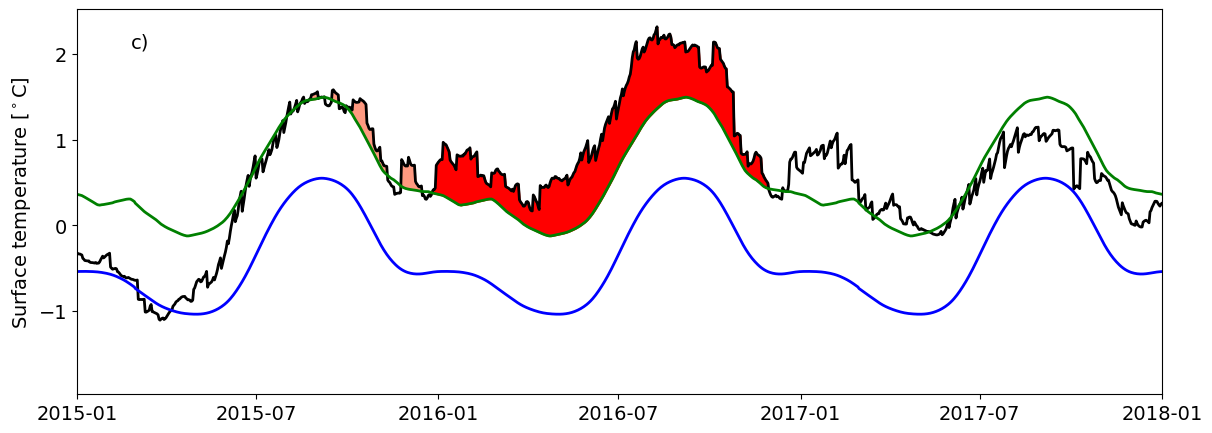

In [38]:
   fig, axs = plt.subplots(1, 1, figsize=(14,5))
   plt.rc('font', size=14)
   plt.rc('axes', labelsize=20)
   plt.rc('xtick', labelsize=20)
   plt.rc('ytick', labelsize=20)
   plt.xticks(fontsize = 14)
   plt.yticks(fontsize = 14)
# Find indices for maximum cumulative event and shade all XX MHWs before and after in pink:
#   for ev0 in np.arange(ev-29, ev+8, 1):
# Spans used for Figure 3 (DO NOT CHANGE!):
#   for ev0 in np.arange(ev-10, ev+10, 1):  # Full Surface
#   for ev0 in np.arange(ev-5, ev+1, 1):    # Full Bottom
#   for ev0 in np.arange(ev-12, ev+20, 1):  # BIT Surface
#   for ev0 in np.arange(ev-6, ev+3, 1):    # BIT Bottom
#   for ev0 in np.arange(ev-30, ev+2, 1):   # NB Surface
   for ev0 in np.arange(ev-5, ev+1, 1):    # NB Bottom
#   for ev0 in np.arange(ev-12, ev+6, 1):   # SB Surface
#   for ev0 in np.arange(ev-10, ev+4, 1):   # SB Bottom
#   for ev0 in np.arange(ev-12, ev+12, 1):  # PS Surface
#   for ev0 in np.arange(ev-6, ev+3, 1):    # PS Bottom
# Spans used for Supplementary Figure (DO NOT CHANGE!):
#   for ev0 in np.arange(ev-18, ev+2, 1):  # Full Surface 1 (1991 - 2005)
#   for ev0 in np.arange(ev-1, ev+1, 1):    # Full Bottom 1 (1991 - 2005)
#   for ev0 in np.arange(ev-16, ev+12, 1):  # Full Surface 2 (2005 - 2022)
#   for ev0 in np.arange(ev-4, ev+1, 1):    # Full Bottom 2 (2005 - 2022)
# Spans used for 2012 Check:
#   for ev0 in np.arange(ev-12, ev+2, 1):  # Full Surface (2012 - 2014)
#   for ev0 in np.arange(ev-4, ev+1, 1):    # Full Bottom (2012 - 2014)
#   for ev0 in np.arange(ev-16, ev+12, 1):  # BIT Surface (2012 - 2014)
#   for ev0 in np.arange(ev-10, ev+1, 1):    # BIT Bottom (2012 - 2014)
#   for ev0 in np.arange(ev-16, ev+12, 1):  # PS Surface (2012 - 2014)
#   for ev0 in np.arange(ev-8, ev+1, 1):    # PS Bottom (2012 - 2014)
#   for ev0 in np.arange(ev-18, ev+6, 1):  # NB Surface (2012 - 2014)
#   for ev0 in np.arange(ev-6, ev+1, 1):    # NB Bottom (2012 - 2014)
      t1 = np.where(t==mhws['time_start'][ev0])[0][0]
      t2 = np.where(t==mhws['time_end'][ev0])[0][0]
      plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], color=(1,0.6,0.5))
# Shade largest cumulative event in dark red:
   t1 = np.where(t==mhws['time_start'][ev])[0][0]
   t2 = np.where(t==mhws['time_end'][ev])[0][0]
   plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
   axs.plot(dates, temp, 'k-', linewidth=2)
   axs.plot(dates, clim['thresh'], 'g-', linewidth=2)
   axs.plot(dates, clim['seas'], 'b-', linewidth=2)
   if surfbot == 1:
      axs.set_xlim(16436, 17532)   # 1.1.2015 - 1.1.2018
#      axs.set_xlim(15340, 16071)   # 1.1.2012 - 1.1.2014
#      axs.set_xlim(7670, 19358)   # 1.1.1991 - 1.1.2023
#      axs.set_xlim(7670, 12784)   # 1.1.1991 - 1.1.2005
#      axs.set_xlim(12784, 19358)   # 1.1.2005 - 1.1.2023
   elif surfbot == 2:
      axs.set_xlim(16436, 17532)   # 1.1.2015 - 1.1.2018
#      axs.set_xlim(15340, 16071)   # 1.1.2012 - 1.1.2014
#      axs.set_xlim(7670, 19358)   # 1.1.1991 - 1.1.2023
#      axs.set_xlim(7670, 12784)   # 1.1.1991 - 1.1.2005
#      axs.set_xlim(12784, 19358)   # 1.1.2005 - 1.1.2023
      axs.set_ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
   if surfbot == 1:
      axs.set_ylabel(r'Surface temperature [$^\circ$C]', size=14)
   elif surfbot == 2:
      axs.set_ylabel(r'Bottom temperature [$^\circ$C]', size=14)
#   axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
   axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))   # Used in Fig. 3 (DO NOT CHANGE!)
#   axs.xaxis.set_minor_locator(mdates.MonthLocator())
#   axs.xaxis.set_major_locator(mdates.YearLocator(base=5))
#   axs.xaxis.set_minor_locator(mdates.YearLocator())
#   axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Inserting panel labels:
   if surfbot == 1:
      if region == 'Full':
         plt.text(.05,.9, 'a)', fontsize = 14, transform = axs.transAxes)
#         plt.text(.05,.9, 'c)', fontsize = 14, transform = axs.transAxes)
      elif region == 'BIT':
         plt.text(.05,.9, 'b)', fontsize = 14, transform = axs.transAxes)
      elif region == 'NB':
         plt.text(.05,.9, 'c)', fontsize = 14, transform = axs.transAxes)
      elif region == 'SB':
         plt.text(.05,.9, 'd)', fontsize = 14, transform = axs.transAxes)
      elif region == 'PS':
         plt.text(.05,.9, 'e)', fontsize = 14, transform = axs.transAxes)
   elif surfbot == 2:
      if region == 'Full':
         plt.text(.05,.9, 'f)', fontsize = 14, transform = axs.transAxes)
#         plt.text(.05,.9, 'd)', fontsize = 14, transform = axs.transAxes)
      elif region == 'BIT':
         plt.text(.05,.9, 'g)', fontsize = 14, transform = axs.transAxes)
      elif region == 'NB':
         plt.text(.05,.9, 'h)', fontsize = 14, transform = axs.transAxes)
      elif region == 'SB':
         plt.text(.05,.9, 'i)', fontsize = 14, transform = axs.transAxes)
      elif region == 'PS':
         plt.text(.05,.9, 'j)', fontsize = 14, transform = axs.transAxes)


   plt.show()

#### Plot an Ocean Monitoring Index (OMI) Figure:

> NB an Ocean Monitoring Index plot is a time series visualization used to track and analyze MHWs relative to a defined climatology.

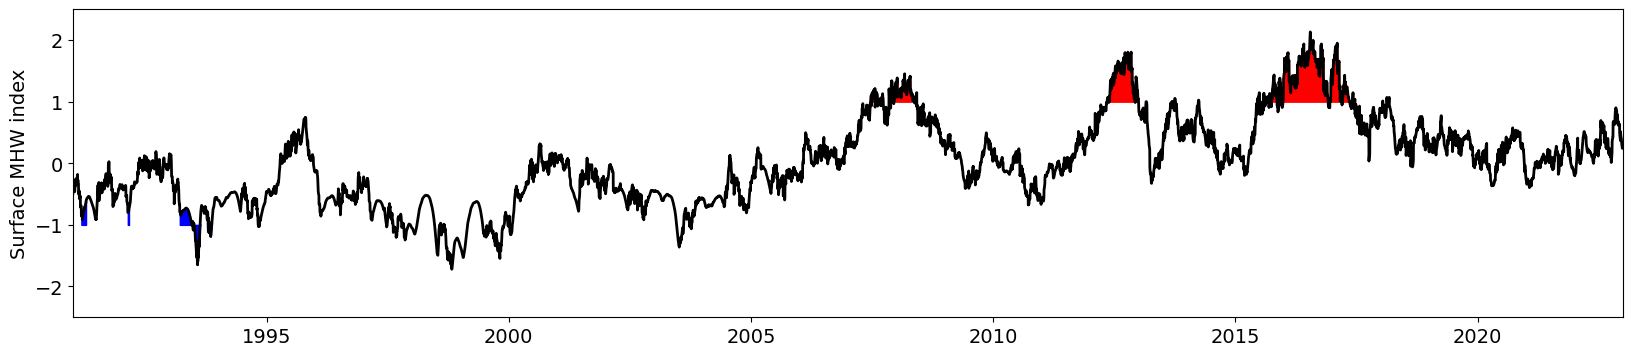

In [39]:
omi_fig = 1
if omi_fig == 1:
  
   omi_index = (temp - clim['seas']) / (clim['thresh'] - clim['seas'])

 
   fig, axs = plt.subplots(1, 1, figsize=(20,4))
   plt.rc('font', size=14)
   plt.rc('axes', labelsize=20)
   plt.rc('xtick', labelsize=20)
   plt.rc('ytick', labelsize=20)
   plt.xticks(fontsize = 14)
   plt.yticks(fontsize = 14)

  
   def find_time_idx(array_t, ts):
      idxs = np.where(array_t == ts)[0]
      return idxs[0] if idxs.size else None

   # warm events
   ev = np.argmax(mhws['intensity_cumulative'])
   n_warm = len(mhws['time_start'])
   if surfbot == 1:
      for ev0 in np.arange(max(0, ev-20), min(n_warm, ev+12), 1):
         t1 = find_time_idx(t, mhws['time_start'][ev0])
         t2 = find_time_idx(t, mhws['time_end'][ev0])
         if t1 is None or t2 is None:
            continue
         plt.fill_between(dates[t1:t2+1], omi_index[t1:t2+1], 1, color='r')
   elif surfbot == 2:
      for ev0 in np.arange(max(0, ev-4), min(n_warm, ev+1), 1):
         t1 = find_time_idx(t, mhws['time_start'][ev0])
         t2 = find_time_idx(t, mhws['time_end'][ev0])
         if t1 is None or t2 is None:
            continue
         plt.fill_between(dates[t1:t2+1], omi_index[t1:t2+1], 1, color='r')

   # cold events
   evc = np.argmax(mhwc['intensity_cumulative'])
   n_cold = len(mhwc['time_start'])
   if surfbot == 1:
      for evc0 in np.arange(max(0, evc-26), min(n_cold, evc+4), 1):
         t1 = find_time_idx(t, mhwc['time_start'][evc0])
         t2 = find_time_idx(t, mhwc['time_end'][evc0])
         if t1 is None or t2 is None:
            continue
         plt.fill_between(dates[t1:t2+1], omi_index[t1:t2+1], -1, color='b')
   elif surfbot == 2:
      for evc0 in np.arange(max(0, evc-9), min(n_cold, evc+2), 1):
         t1 = find_time_idx(t, mhwc['time_start'][evc0])
         t2 = find_time_idx(t, mhwc['time_end'][evc0])
         if t1 is None or t2 is None:
            continue
         plt.fill_between(dates[t1:t2+1], -1, omi_index[t1:t2+1], color='b')

   
   axs.plot(dates, omi_index, 'k-', linewidth=2)


   axs.set_xlim(7670, 19358)   # 1.1.1991 - 1.1.2023
   axs.set_ylim(-2.5, 2.5)


   if surfbot == 1:
      axs.set_ylabel(r'Surface MHW index', size=14)
   elif surfbot == 2:
      axs.set_ylabel(r'Bottom MHW index', size=14)

 
   axs.xaxis.set_major_locator(mdates.YearLocator(base=5))

   plt.show()


#### Plot a bar chart showing the duration of all events:

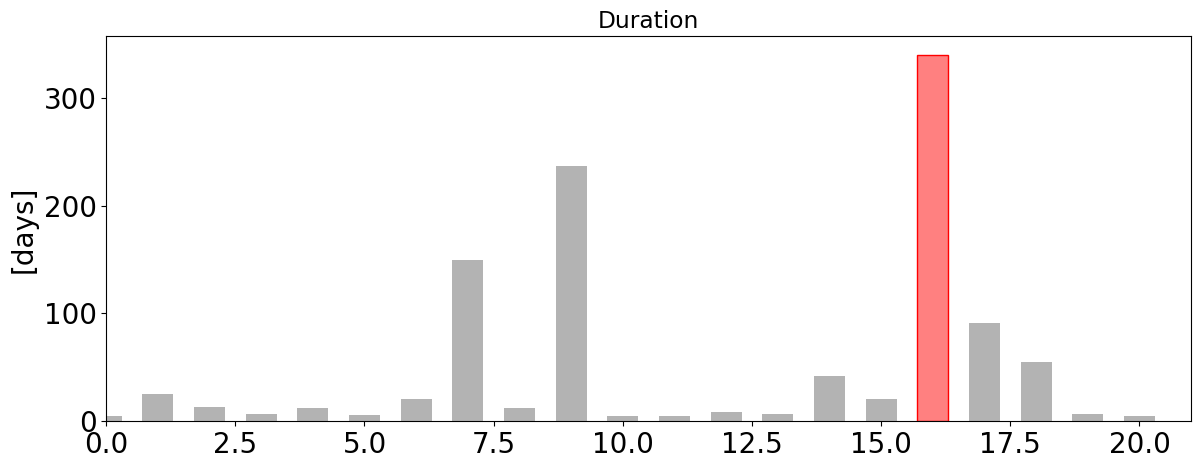

In [40]:
barchart = 1
if barchart == 1:
   ev = np.argmax(mhws['intensity_cumulative'])

   plt.figure(figsize=(14,5))

   plt.subplot(1,1,1)
   evMax = np.argmax(mhws['duration'])
   plt.bar(range(mhws['n_events']), mhws['duration'], width=0.6, color=(0.7,0.7,0.7))
   plt.bar(evMax, mhws['duration'][evMax], width=0.6, color=(1,0.5,0.5))
   plt.bar(ev, mhws['duration'][ev], width=0.6, edgecolor=(1,0.,0.), color='none')
   plt.xlim(0, mhws['n_events'])
   plt.ylabel('[days]')
   plt.title('Duration')
   plt.show()


#### Plot timeseries of the number of events (frequency), max intensity, and duration of all events:

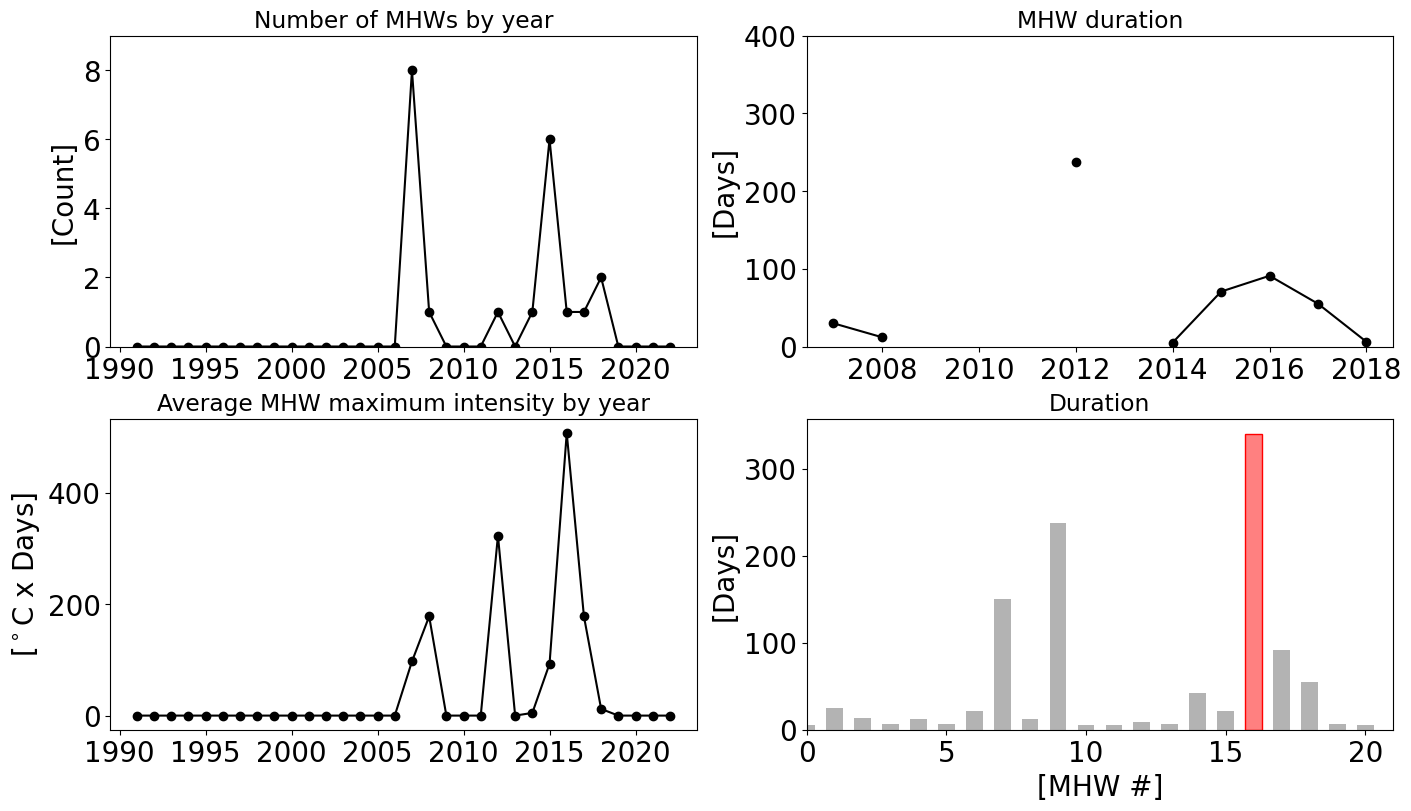

In [41]:
tseries = 1
if tseries == 1:

    fig, axes = plt.subplots(2, 2,
                             figsize=(14, 8),
                             constrained_layout=True)
    ax1, ax2, ax3, ax4 = axes.flat


    ax1.plot(mhwBlock['years_centre'], mhwBlock['count'], 'k-o')
    ax1.set_ylim(0, 9)
    ax1.set_ylabel('[Count]')
    ax1.set_title('Number of MHWs by year')


    ax2.plot(mhwBlock['years_centre'], mhwBlock['duration'], 'k-o')
    ax2.set_ylim(0, 400)
    ax2.set_ylabel('[Days]')
    ax2.set_title('MHW duration')


    ax3.plot(mhwBlock['years_centre'], mhwBlock['total_icum'], 'k-o')
    ax3.set_ylabel(r'[$^\circ$C x Days]')
    ax3.set_title('Average MHW maximum intensity by year')


    ev  = np.argmax(mhws['intensity_cumulative'])
    evMax = np.argmax(mhws['duration'])
    ax4.bar(range(mhws['n_events']),
            mhws['duration'],
            width=0.6,
            color=(0.7, 0.7, 0.7))
    ax4.bar(evMax,
            mhws['duration'][evMax],
            width=0.6,
            color=(1, 0.5, 0.5))
    ax4.bar(ev,
            mhws['duration'][ev],
            width=0.6,
            edgecolor=(1, 0, 0),
            color='none')
    ax4.set_xlim(0, mhws['n_events'])
    ax4.set_xlabel('[MHW #]')
    ax4.set_ylabel('[Days]')
    ax4.set_title('Duration')

    plt.show()
